In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from pathlib import Path
import sys
import pickle
import time
sys.path.append("..")

import matplotlib.pyplot as plt
from falkon.kernels import GaussianKernel
from falkon import FalkonOptions

from nyskoop.data.DESRES_proteins import load_traj_metadata, pairwise_distance_generator
from experiment_helpers import *

ModuleNotFoundError: No module named 'mdtraj'

In [4]:
from deeptime.clustering import KMeans
from deeptime.markov.msm import MaximumLikelihoodMSM
import mdtraj
import nglview as nv

In [5]:
set_matplotlib_rc(24, 26, 28)

In [6]:
COMPUTE_DISTANCES = False
TRAIN = False
SHOW_PROTS = False

protein_name = "2J0F"

output_dir = Path("../analysis_outputs/bigprot")
output_dir.mkdir(exist_ok=True, parents=True)
datasets_path = "../datasets"
distances_path = f"/data/giacomo/{protein_name}_dist.npy"

In [7]:
def load_trajectory(protein_id, base_path, superpose_sel="name CA"):
    mdata = load_traj_metadata(protein_id=protein_id, base_path=base_path)
    traj = mdtraj.load(mdata['trajectory_files'], top=mdata['topology_path'])
    sel = traj.top.select(superpose_sel)
    traj = traj.superpose(traj, frame=0, atom_indices=sel)
    return traj

In [8]:
if SHOW_PROTS:
    traj = load_trajectory(protein_name, datasets_path)

### Compute and save distances

In [9]:
if COMPUTE_DISTANCES:
    all_dist = []
    for i, pwise_distances in enumerate(pairwise_distance_generator(traj)):
        all_dist.append(pwise_distances)
    all_dist = np.concatenate(all_dist)
    np.save(distances_path, all_dist)
    del all_dist

### Data loading

In [10]:
data = np.load(distances_path)  # 41GB, so takes some time!

In [11]:
data = torch.from_numpy(data)
data.shape, data.dtype

(torch.Size([1044000, 10296]), torch.float32)

### Normalization

In [12]:
if True:
    feature_norm = torch.linalg.norm(data, dim=0).view(1, -1)
    feature_mean = torch.mean(data, dim=0).view(1, -1)
    data -= feature_mean
    data /= feature_norm

## Model training

### Splitting
only do this if training

In [13]:
def get_data_split(data, q, subsample, test_fraction, val_fraction, seed):
    np.random.seed(seed)
    data_x = data[:-q]
    data_y = data[q:]
    data_x = data_x[::subsample]
    data_y = data_y[::subsample]
    tot_n = data_x.shape[0]
    rnd_ids = np.random.permutation(tot_n)
    test_n = int(tot_n * test_fraction)
    val_n = int(tot_n * val_fraction)
    train_n = tot_n - test_n - val_n
    test_ids = rnd_ids[:test_n]
    train_ids = rnd_ids[test_n:test_n + train_n]
    val_ids = rnd_ids[-val_n:]
    train_x, train_y = data_x[train_ids], data_y[train_ids]
    test_x, test_y = data_x[test_ids], data_y[test_ids]
    val_x, val_y = data_x[val_ids], data_y[val_ids]
    return [
        (train_x, train_y),
        (val_x, val_y),
        (test_x, test_y),
    ]

In [14]:
q = 50
subsample = 1
if TRAIN:
    (train_x, train_y), (val_x, val_y), (test_x, test_y) = get_data_split(
        data=data, q=q, subsample=subsample, test_fraction=1/5, val_fraction=1/5, seed=0
    )
    print(f"{train_x.shape[0]} training points")
    print(f"{test_x.shape[0]} test points")
    print(f"{val_x.shape[0]} validation points")
    del data  # for memory saving

### train

```
errors, with PCR 1k, s=.1 => 2.20e-4
errors, with PCR 1k, s=.08 => 2.19-4
errors, with PCR 1k, s=.05 => 2.19-4
errors, with PCR 1k, s=.15 => 2.20-4
errors, with PCR 2k, s=.1 => 2.20-4
errors, with PCR 3k, s=.1 => 2.20-4
errors, with PCR 3k, s=.2 => 2.20-4
errors, with PCR 3k, s=.4 => 2.24-4
errors, with PCR 3k, s=.01 => 2.28-4
errors, with PCR 1k, s=.1 =>
    n_comp 10 => 2.14
    n_comp 3 => 2.27
    n_comp 20 => 2.11


with RRR 1k, s=.08 => 2.34e-4
with RRR 1k, s=.05 => 2.47e-4
with RRR 1k, s=.12 => 2.52e-4
with RRR 1k, s=.1 => 2.34e-4
with RRR 1k, s=.1, p1e-8 => fail
with RRR 1k, s=.1, p1e-7 => fail
with RRR 1k, s=.1, p1e-10 => 2.34e-4
with RRR 2k, s=.1, p1e-9 => 2.52e-4
with RRR 1k, s=.1, p1e-9 => 2.52e-4

Full data, PCR 5k, 10c, s=.1 => 2.1548e-4
           PCR 5k, 10c, s=0.05 => 2.1433e-4
           PCR 5k, 10c, s=0.025 => 2.1261e-04, 2nd try same. But efuns are crap.
           PCR 5k, 10c, s=0.01 => 2.2310e-04
           
           RRR 5k, 10c, s=0.1 => not real, second eigenvalue is really small.
           RRR 5k, 10c, s=0.01 => evals good. 2.2256e-04 slightly weird efuns but seems ok! Saved at `rrr_m5k_full`
           RRR 5k, 10c, s=0.02 => evals good. 2.1282e-04 basically the same efuns as the PCR. took 600s to train. Saved at `rrr_m5k_full_s0.02` xx
           RRR 5k, 10c, s=0.005 => evals not good 2.3877e-04
```

In [15]:
model_args = {
    "fastpcr": {
        "num_components": 10,
        "M": 10000,
        "kernel": GaussianKernel(.02, opt=FalkonOptions(use_cpu=False)),
        "oversampling": 2,
        "n_iter": 1,
        "power_iteration_normalizer": "none",
    },
    "pcr": {
        "num_components": 10,
        "M": 5000,
        "kernel": GaussianKernel(.02, opt=FalkonOptions(use_cpu=True)),
        "svd_solver": "full",
    },
    "rrr": {
        "penalty": 1e-9,
        "num_components": 10,
        "M": 5000,
        "kernel": GaussianKernel(
            0.02,
            opt=FalkonOptions(use_cpu=True)
        ),
    },
}

In [16]:
torch.cuda.empty_cache()

In [17]:
if TRAIN:
    model = "fastpcr"
    model_name = f"{model}_m{model_args[model]['M']}_full_s{model_args[model]['kernel'].sigma.item()}"
    t_s = time.time()
    est = train_est(train_x, train_y, kind=model, **model_args[model])
    t_elapsed = time.time() - t_s
    print(f"Trained {model_name} estimator in {t_elapsed:.2f}s.")

In [18]:
if TRAIN:
    evals, efun_left, efun_right = est.eigenfunctions()
    print(evals)
    tscales = -1 / np.log(evals.real)
    tscales_real = tscales * q
    print(f"Time-scales: {tscales_real[1:] * 0.2}ns")

In [19]:
if TRAIN:
    est_rmse = torch.sqrt(torch.mean(torch.square(
        est.predict(test_x) - test_y
    )))
    print(f"RMSE = {est_rmse:.4e}")

## More timings

**fast PCR**

1)
```
over=2, niter=1(none), cpu
Trained fastpcr_m5000_full_s0.02 estimator in 737.82s.
Time-scales: 252.4249,  51.7959,  21.2589,  15.4206,  12.6636,  10.4751,   8.9180, 8.1229,   5.4072
RMSE = 2.1265e-04
```

2)
```
over=2, niter=1(none), gpu
Trained fastpcr_m5000_full_s0.02 estimator in 107.13s.
Time-scales: 238.2880,  53.0895,  20.0636,  15.1992,  12.7454,  10.1831,   8.2779, 7.6753,   5.0507
RMSE = 2.1267e-04
```

3)
```
over=2, niter=1(none), gpu
Trained fastpcr_m5000_full_s0.01 estimator in 91s
Time-scales: [60.7907, 40.6120, 33.0751, 22.7590, 19.7206, 14.9092, 12.5123,  6.9295, 5.506
RMSE = 2.2290e-04
```

4)
```
over=2, niter=1(none), gpu
Trained fastpcr_m5000_full_s0.03 estimator in 106s
Time-scales: 160.2225,  45.3084,  20.3443,  13.3709,  11.8567,   9.5619,   9.0152, 7.6552,   5.2203
RMSE = 2.1271e-04
```

5)
```
over=2, niter=1(none), gpu
Trained fastpcr_m10000_full_s0.02 estimator in 187s
Time-scales: 206.1167,  46.3872,  20.1691,  13.5906,  12.3770,  10.1737,   8.2322, 7.8161,   5.3880
RMSE = 2.1263e-04
```

#### Save/load model

In [20]:
if TRAIN:
    with open(output_dir / f"{model_name}.pkl", "wb") as fh:
        pickle.dump(est, fh)
else:
    model_name = "fastpcr_m10000_full_s0.02"
    with open(output_dir / f"{model_name}.pkl", "rb") as fh:
        est = pickle.load(fh)

## Model analysis

In [21]:
def build_msm(n_clusters, n_pcca_clusters, efun_vals):
    efun_vals = efun_vals.numpy().real
    clustering = KMeans(n_clusters=n_clusters, fixed_seed=13).fit(
        efun_vals
    ).fetch_model()
    assignments = clustering.transform(efun_vals)
    msm = MaximumLikelihoodMSM().fit(assignments, lagtime=1).fetch_model()
    pcca = msm.pcca(n_metastable_sets=n_pcca_clusters)
    return pcca.memberships[assignments]

In [22]:
evals, efun_left, efun_right = est.eigenfunctions()
evals

tensor([0.9876-0.j, 0.9526-0.j, 0.7998-0.j, 0.6005-0.j, 0.4733-0.j, 0.4606-0.j, 0.3723-0.j,
        0.2857-0.j, 0.2518-0.j, 0.1542-0.j])

(0.0, 1.05)

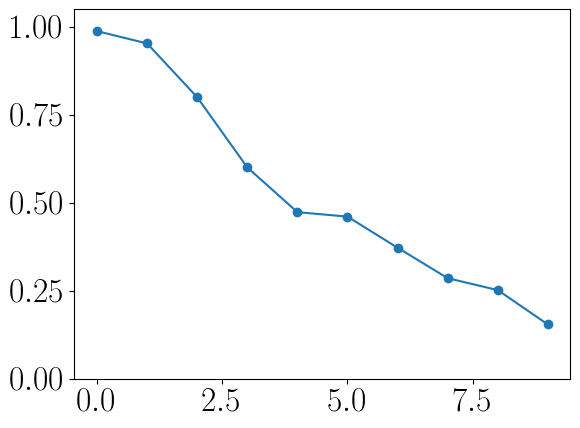

In [23]:
fig, ax = plt.subplots()
ax.plot(evals.real, marker='o')
ax.set_ylim([0.0, 1.05])

(0.0, 1.05)

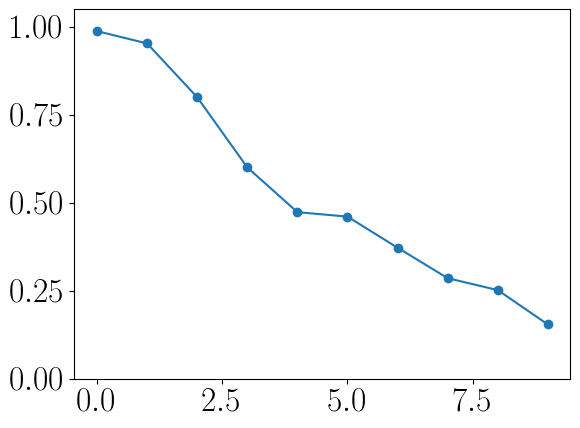

In [24]:
fig, ax = plt.subplots()
ax.plot(evals.real, marker='o')
ax.set_ylim([0.0, 1.05])

In [29]:
efun_subsample = 5
efun_vals = efun_right(data[::efun_subsample])
efun_vals.shape

torch.Size([208800, 10])

In [30]:
pcca_clusters = build_msm(50, 3, efun_vals[:, :3])

In [31]:
pcca_clusters_hard = np.argmax(pcca_clusters, 1)
np.unique(pcca_clusters_hard, return_counts=True)

(array([0, 1, 2]), array([ 22329,  37026, 149445]))

### Plot proteins

!!Warning: Plotting is unstable in jupyter notebooks. For less frustration do the training first and save results, and do plotting by loading results. You might have to restart the notebook multiple times if you want to change plotting parameters.

#### First cluster

In [32]:
if SHOW_PROTS:
    view = nv.NGLWidget()

    cluster_idx = 2
    max_views = 60
    components = []
    for time_idx in np.where(pcca_clusters_hard == cluster_idx)[0][:max_views]:
        components.append(view.add_component(traj[time_idx * efun_subsample]))
    view

In [33]:
if SHOW_PROTS:
    view.render_image(factor=4, trim=True)

#### Second cluster

In [34]:
if SHOW_PROTS:
    view = nv.NGLWidget()

    cluster_idx = 1
    max_views = 60
    components = []
    for time_idx in np.where(pcca_clusters_hard == cluster_idx)[0][:max_views]:
        components.append(view.add_component(traj[time_idx * efun_subsample]))
    view

In [35]:
if SHOW_PROTS:
    view.render_image(factor=4, trim=True)

#### Third cluster

In [36]:
if SHOW_PROTS:
    view = nv.NGLWidget()

    cluster_idx = 0
    max_views = 60
    components = []
    for time_idx in np.where(pcca_clusters_hard == cluster_idx)[0][:max_views]:
        components.append(view.add_component(traj[time_idx * efun_subsample]))
    view

In [37]:
if SHOW_PROTS:
    view.render_image(factor=4, trim=True)

### Plot MSM States

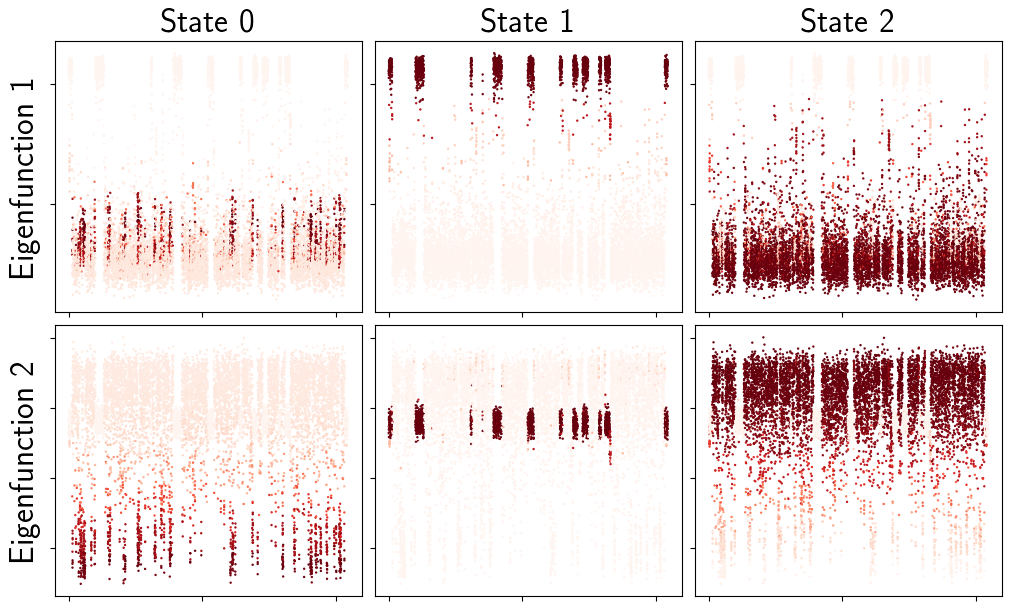

In [32]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 6), constrained_layout=True)
cmap = plt.cm.Reds
subs = 20
for j in range(ax.shape[0]):
    for i in range(ax.shape[1]):
        ax[j, i].scatter(
            np.arange(efun_vals[::subs].shape[0]), 
            efun_vals[::subs, j + 1].real, 
            s=0.5, alpha=1.0, c=pcca_clusters[::subs, i], 
            cmap=cmap)
        ax[j, i].set_yticklabels([])
        ax[j, i].set_xticklabels([])
        if j == 0:
            ax[j, i].set_title(f"State {i}")
        if i == 0:
            ax[j, i].set_ylabel(f"Eigenfunction {j + 1}", fontsize=24)
# fig.savefig(output_dir / "state_efuns.png", dpi=300)